In [88]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from keras import backend as K

DATASET = 'dataset_reduzido.csv'

pd.read_csv(DATASET).shape

(643, 9)

In [86]:
def get_PCA(df, start, end):
    features = list(df.columns[0:-1])
    s = int(start * len(features))
    e = int(end * len(features))
    features = features[s:e]
    target = df.columns[-1]
    x = df.loc[:, features].values
    y = df.loc[:,[target]].values
    y = [ v[0] for v in y ]
    pca = PCA(n_components=2)
    vectors = pd.DataFrame(pca.fit_transform(x))
    vectors['label'] = y
    return vectors

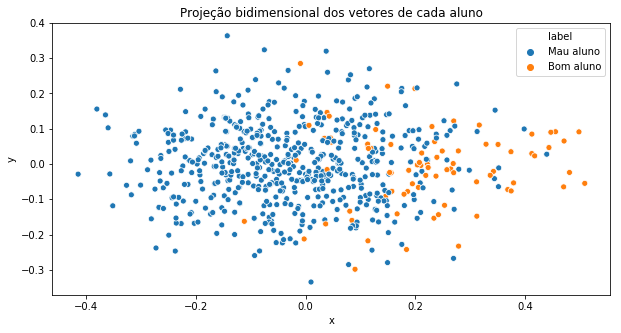

In [87]:
dataset = pd.read_csv(DATASET)

dataplot = get_PCA(dataset, 0.5, 1)
dataplot['label'] = dataplot['label'].apply(lambda x: 'Bom aluno' if x == 1.0 else 'Mau aluno')
ax = sns.scatterplot(x=0, y=1, hue='label', data=dataplot)
ax.set(ylabel='y')
ax.set(xlabel='x')
ax.set_title('Projeção bidimensional dos vetores de cada aluno')
pass

Percebemos que existe um hiperplano separando as duas classes. Portanto, considerado isso e também o baixo volume de dados, decidiu-se que o modelo de Perceptron é uma arquitetura adequada.

In [112]:
dataset = pd.read_csv(DATASET)

X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values


labels = LabelEncoder()
y = labels.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


K.tensorflow_backend._get_available_gpus()

# Initialising the ANN
classifier = Sequential()

# Adding the Single Perceptron or Shallow network
classifier.add(Dense(output_dim=128, 
                     init='uniform', 
                     activation='relu', 
                     input_dim=8))
# Adding dropout to prevent overfitting
classifier.add(Dropout(p=0.1))
# Adding the output layer
classifier.add(Dense(output_dim=1, 
                     init='uniform', 
                     activation='sigmoid'))

# criterion loss and optimizer 
classifier.compile(optimizer='adam',
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, 
               y_train, 
               batch_size=100, 
               nb_epoch=80)



Epoch 1/80
450/450 [==============================] - 1s 3ms/step - loss: 0.6913 - acc: 0.6222
Epoch 2/80
450/450 [==============================] - 0s 43us/step - loss: 0.6733 - acc: 0.8356
Epoch 3/80
450/450 [==============================] - 0s 36us/step - loss: 0.6543 - acc: 0.8778
Epoch 4/80
450/450 [==============================] - 0s 37us/step - loss: 0.6335 - acc: 0.8778
Epoch 5/80
450/450 [==============================] - 0s 34us/step - loss: 0.6114 - acc: 0.8778
Epoch 6/80
450/450 [==============================] - 0s 29us/step - loss: 0.5863 - acc: 0.8778
Epoch 7/80
450/450 [==============================] - 0s 36us/step - loss: 0.5585 - acc: 0.8778
Epoch 8/80
450/450 [==============================] - 0s 37us/step - loss: 0.5298 - acc: 0.8778
Epoch 9/80
450/450 [==============================] - 0s 34us/step - loss: 0.5008 - acc: 0.8778
Epoch 10/80
450/450 [==============================] - 0s 34us/step - loss: 0.4703 - acc: 0.8778
Epoch 11/80
450/450 [===================

[[164   4]
 [  9  16]]


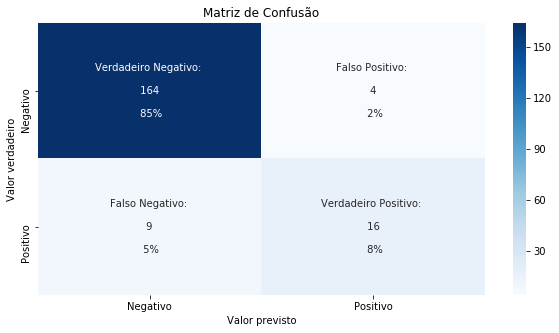

In [119]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
ax.set(ylabel='Valor verdadeiro')
ax.set(xlabel='Valor previsto')
labels = ['Verdadeiro Negativo', 
          'Falso Positivo', 
          'Falso Negativo', 
          'Verdadeiro Positivo']
ax.set(yticklabels=['Negativo','Positivo'])
ax.set(xticklabels=['Negativo','Positivo'])
count = 0
bacc = []
for idx, text in enumerate(ax.texts):
    label = int(text.get_text())
    count += label
    bacc.append(label)

acc1 = bacc[0] / ( bacc[0] + bacc[2] )
acc2 = bacc[3] / ( bacc[1] + bacc[3] ) 
balanced_accuracy = ( acc1 + acc2 ) / 2
for idx,text in enumerate(ax.texts):
    square = text.get_text()
    percent = int(text.get_text()) / count
    percent = "{0:.0%}".format(percent)
    box_text = "{0}: \n \n {1} \n \n {2}".format(labels[idx], square, percent)
    text.set_text(box_text)
ax.set_title('Matriz de Confusão')
pass

In [120]:
value = ( cm[0][0] + cm[1][1] ) / ( cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
value = "{0:.0%}".format(value)
print('Acurácia total : ', value )

Acurácia total :  93%


In [121]:
value = ( cm[1][1] ) / ( cm[0][1] + cm[1][1]) 
value = "{0:.0%}".format(value)
print('Acurácia de distinção entre Falso positivo / Verdadeiro positivo : ', value )

Acurácia de distinção entre Falso positivo / Verdadeiro positivo :  80%
